This notebook uses some codes provided in https://github.com/Luolc/AdaBound for visulaizaiton

# Empirical Study on CIFAR-10

In [2]:
import os
%matplotlib notebook
import matplotlib.pyplot as plt
import torch
import numpy as np


plt.rcParams.update({
    "font.family": "serif",  # use serif/main font for text elements
    #"font.size"   : 15,
    "text.usetex": True,  # use inline math for ticks
    "pgf.rcfonts": False,  # don't setup fonts from rc parameters
    "pgf.preamble": "\n".join([
        "\\usepackage{units}",  # load additional packages
        "\\usepackage{metalogo}",
        "\\usepackage{unicode-math}",  # unicode math setup
        r"\setmathfont{xits-math.otf}",
        r"\setmainfont{DejaVu Serif}",  # serif font via preamble
    ])
})

#LABELS = ['SGD', 'AdaGrad', 'Adam', 'AMSGrad', 'AdaBound', 'AMSBound']
LABELS = ['SRMM', 'SMM', 'SGD', 'AdaGrad', 'Adam', 'AMSGrad']



/Users/hanbaek/opt/miniconda3/envs/hlyuenv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def get_folder_path(use_pretrained=True):
    path = 'curve'
    if use_pretrained:
        path = os.path.join(path, 'pretrained')
    return path

In [4]:
def get_curve_data(use_pretrained=True, model='ResNet'):
    folder_path = get_folder_path(use_pretrained)
    filenames = [name for name in os.listdir(folder_path) if name.startswith(model.lower())]
    paths = [os.path.join(folder_path, name) for name in filenames]
    keys = [name.split('-')[1] for name in filenames]
    return {key: torch.load(fp) for key, fp in zip(keys, paths)}

In [98]:
def plot(use_pretrained=True, model='ResNet', optimizers=None, curve_type='train'):
    assert model in ['ResNet', 'DenseNet'], 'Invalid model name: {}'.format(model)
    assert curve_type in ['train', 'test'], 'Invalid curve type: {}'.format(curve_type)
    assert all(_ in LABELS for _ in optimizers), 'Invalid optimizer'
    
    curve_data = get_curve_data(use_pretrained, model=model)
    
    plt.figure()
    plt.title('{} Accuracy for {} on CIFAR-10'.format(curve_type.capitalize(), model))
    plt.xlabel('Epoch')
    plt.ylabel('{} Accuracy %'.format(curve_type.capitalize()))
    plt.ylim(80, 101 if curve_type == 'train' else 96)
    plt.xlim(0, 130)
    
    for optim in optimizers:
        linestyle = '-' if 'SRMM' in optim else '-'
        marker = 'o' if 'SRMM' in optim else ''
        if 'SMM' in optim:
            marker = '*'
        
        accuracies = np.array(curve_data[optim.lower()]['{}_acc'.format(curve_type)])
        if optim == "SRMM":
            optim = "SRMM"
        if optim == "SGD":
            optim = "SGD-HB"
        plt.plot(accuracies, label=optim, ls=linestyle, marker=marker, markevery=5)
        

        
    plt.grid(ls='--')
    plt.legend(ncol=2)
    plt.show()
    save_name = "{}_{}".format(model, curve_type)+".pdf" 
    plt.savefig(save_name, bbox_inches="tight")

The above function is for plotting the learning curves. To use your own data points, set `use_pretrained` as `False`.

## ResNet

First, let's see the results with ResNet-34.

<IPython.core.display.Javascript object>


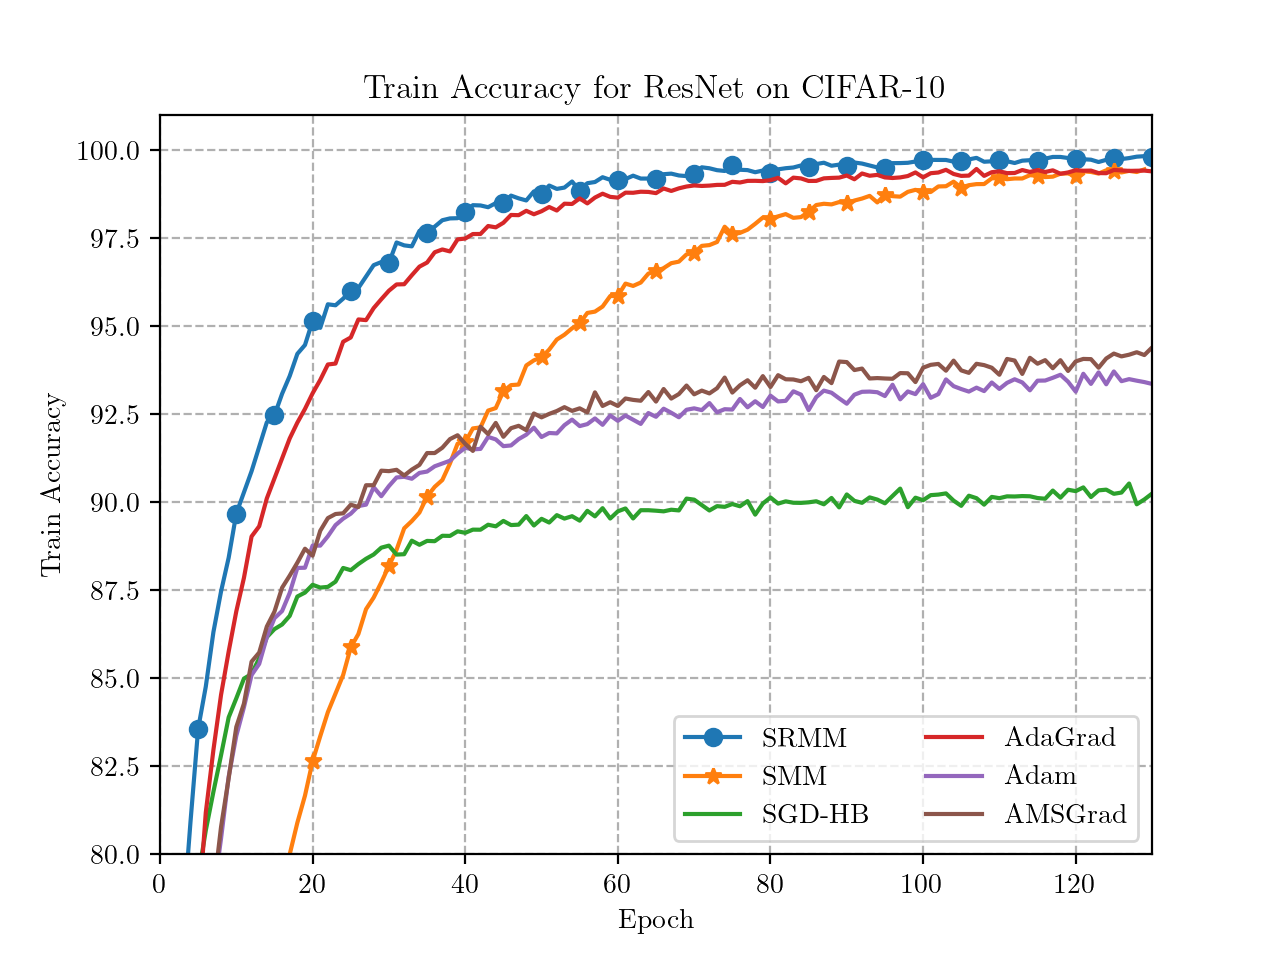

<IPython.core.display.Javascript object>


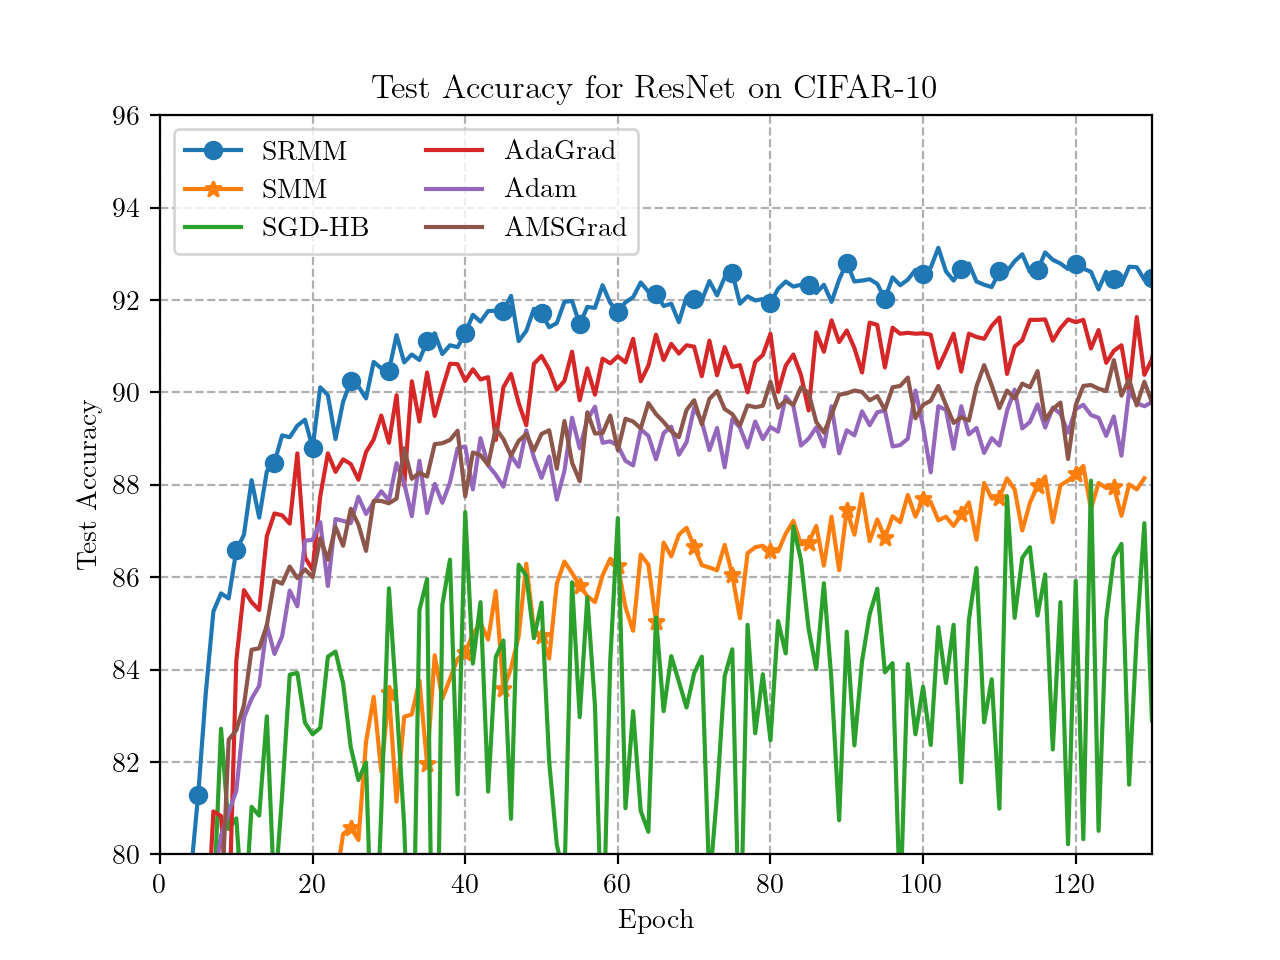

In [105]:
plot(use_pretrained=True, model='ResNet', optimizers=LABELS, curve_type='train')
plot(use_pretrained=True, model='ResNet', optimizers=LABELS, curve_type='test')

We can see that adaptive methods such as AdaGrad, Adam and AMSGrad appear to perform better than the non-adaptive ones early in training. 
But by epoch 150 when the learning rates are decayed, SGD begins to outperform those adaptive methods. 
As for our methods, AdaBound and AMSBound, they converge as fast as adaptive ones and achieve a higher accuracy than SGD on the test set at the end of training. 
In addition, compared with their prototypes, their performances on the unseen data (test set) are enhanced evidently.

You may observe a slight decline of the test accuracy with SGD.
Since the decline also occurs in training, this may not be caused by overfitting but some other reasons.
This behavior indicates the unstable performance of SGD to some extent, which is similar to the observation reported in [He et al. (2016)](https://arxiv.org/abs/1512.03385).

## DensetNet

Here're the results with DenseNet-121.

<IPython.core.display.Javascript object>


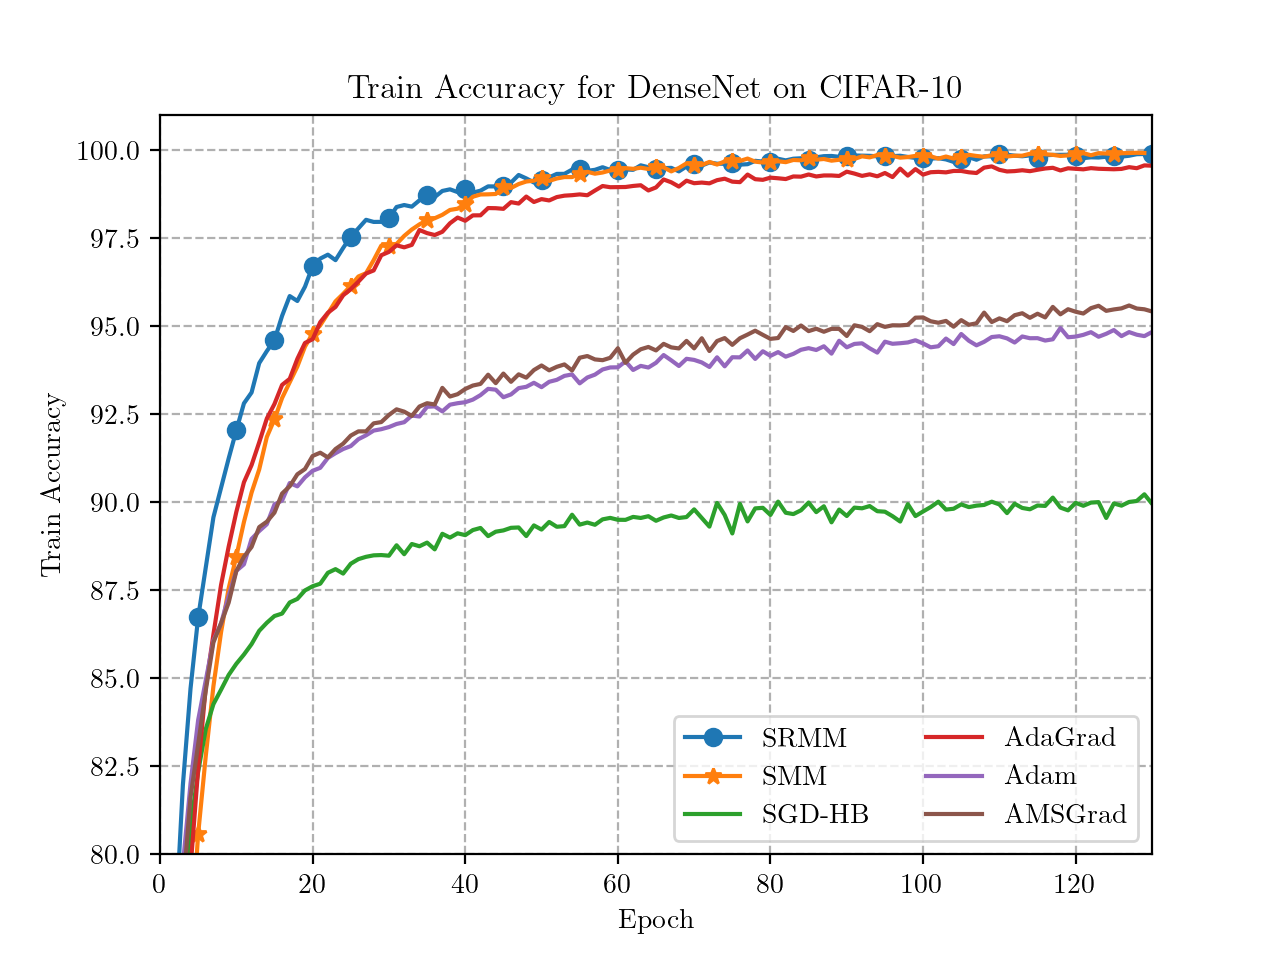

<IPython.core.display.Javascript object>


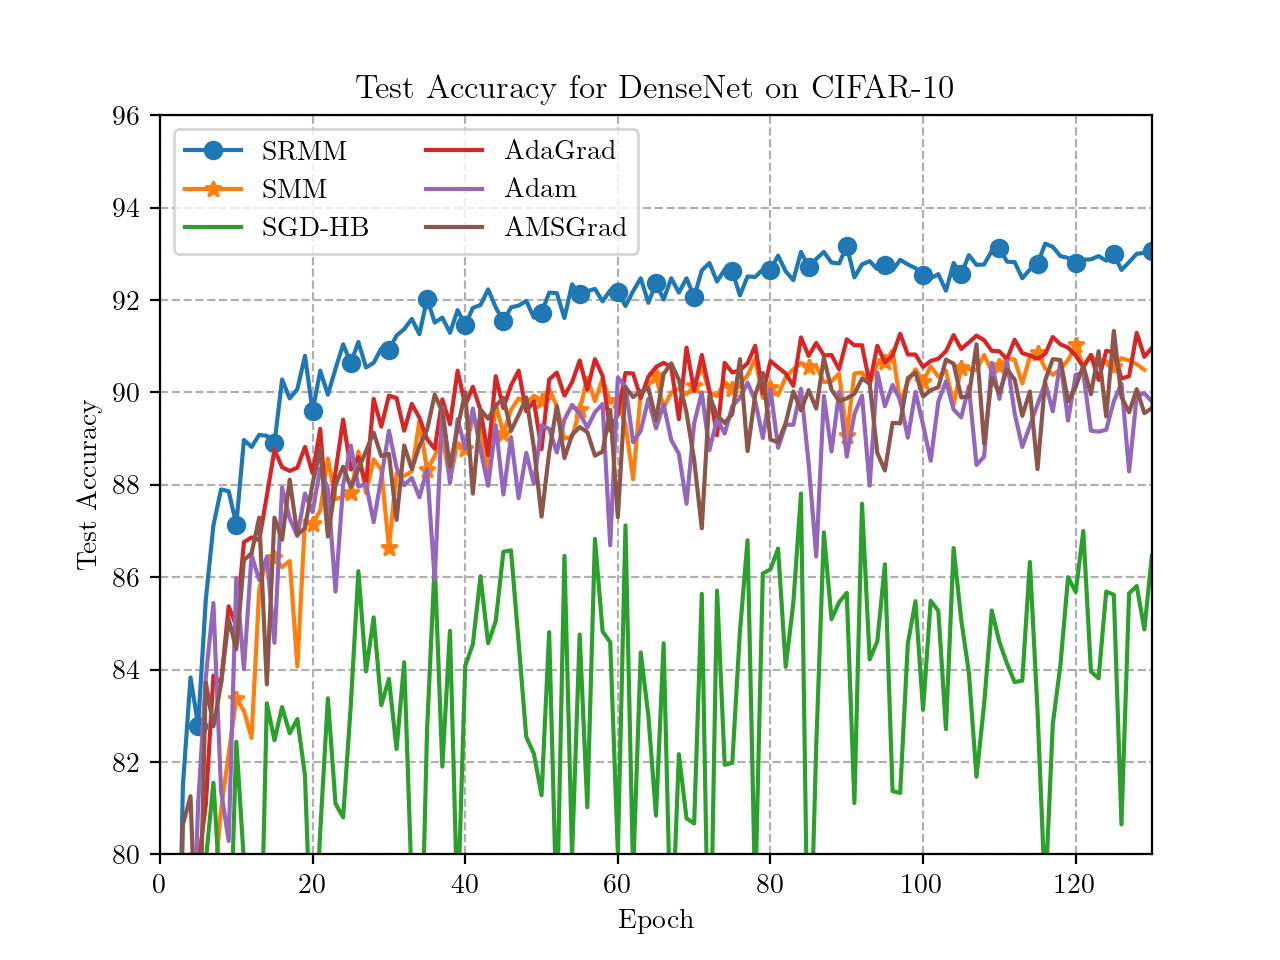

In [106]:
plot(use_pretrained=True, model='DenseNet', optimizers=LABELS, curve_type='train')
plot(use_pretrained=True, model='DenseNet', optimizers=LABELS, curve_type='test')

As is expected, the overall performance of each algorithm on DenseNet-121 is similar to that on ResNet-34. 
Despite the relative bad generalization ability of adaptive methods, our proposed methods overcome this drawback by allocating bounds for their learning rates and obtain almost the best accuracy on the test set for both DenseNet and ResNet on CIFAR-10.